In [1]:
import os
import itertools

import pandas
import matplotlib
import seaborn
import lifelines

from lifelines.statistics import logrank_test

In [2]:
FIG_SIZE = (6, 3)
FIG_SIZE_WIDE = (14, 3)
FIGURE_PATH = '../figures'

ECOSYSTEMS = ['Cargo', 'NPM', 'Packagist', 'Rubygems']
DATE_RANGE = pandas.to_datetime('2013-01-01'), pandas.to_datetime('2018-01-01')
CENSOR_DATE = pandas.to_datetime('2018-03-15')
P_VALUE = 0.05  # Not corrected

PALETTE = seaborn.color_palette(n_colors=len(ECOSYSTEMS))
SEC_PALETTE = seaborn.color_palette('muted')

COLORS = {e: PALETTE[i] for i, e in enumerate(ECOSYSTEMS)}

In [3]:
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

def _savefig(fig, name):
    fig.savefig(
        os.path.join(FIGURE_PATH, '{}.pdf'.format(name)),
        bbox_inches='tight'
    )

# Disable figure export
SAVEFIG = True
savefig = _savefig if SAVEFIG else lambda x, y: None

# Load and transform data

In [4]:
df_versions = dict()
for ecosystem in ECOSYSTEMS:
    print('Loading', ecosystem)
    df_versions[ecosystem] = (
        pandas.read_csv(
            '../data/{}-versions.csv.gz'.format(ecosystem),
        )
        .assign(
            date=lambda d: pandas.to_datetime(d['date'], infer_datetime_format=True),
        )
    )
    
    print('.. identify next release')
    df_versions[ecosystem] = (
        df_versions[ecosystem]
        .merge(
            (
                df_versions[ecosystem]
                .assign(rank=lambda d: d['rank'] - 1)
                .rename(columns={'date': 'next_date'})
                [['package', 'rank', 'next_date']]
            ),
            how='left',
            on=['package', 'rank']
        )
    )
    
print('Done!')

Loading Cargo
.. identify next release
Loading NPM
.. identify next release
Loading Packagist
.. identify next release
Loading Rubygems
.. identify next release
Done!


In [5]:
mask_semver = {
    'Semver': lambda d: (~d['allows_major'] & d['allows_minor'] & ~d['dev']) | (d['dev'] & ~d['allows_patch']),
    'Cargo': lambda d: (~d['allows_major'] & d['allows_minor'] & ~d['dev']) | (d['dev'] & ~d['allows_minor'] & d['allows_patch']),
    'NPM': lambda d: (~d['allows_major'] & d['allows_minor'] & ~d['dev']) | (d['dev'] & ~d['allows_minor'] & d['allows_patch']),
    'Packagist': lambda d: (~d['allows_major'] & d['allows_minor'] & ~d['dev']) | (d['dev'] & ~d['allows_minor'] & d['allows_patch']),
    'Rubygems': lambda d: (~d['allows_major'] & d['allows_minor']),
}
 
mask_permissive = {
    'Semver': lambda d: d['allows_major'] | (d['dev'] & d['allows_patch']),
    'Cargo': lambda d: d['allows_major'] | (d['dev'] & d['allows_minor']),
    'NPM': lambda d: d['allows_major'] | (d['dev'] & d['allows_minor']),
    'Packagist': lambda d: d['allows_major'] | (d['dev'] & d['allows_minor']),
    'Rubygems': lambda d: d['allows_major'],
}

mask_restrictive = {
    'Semver': lambda d: ~d['allows_minor'] & ~d['dev'],
    'Cargo': lambda d: ~d['allows_patch'] | (~d['dev'] & ~d['allows_minor']),
    'NPM': lambda d: ~d['allows_patch'] | (~d['dev'] & ~d['allows_minor']),
    'Packagist': lambda d: ~d['allows_patch'] | (~d['dev'] & ~d['allows_minor']),
    'Rubygems': lambda d: ~d['allows_minor'],
}

In [6]:
df_dependencies = dict()
for ecosystem in ECOSYSTEMS:
    print('Loading', ecosystem)
    df_dependencies[ecosystem] = (
        pandas.read_csv(
            '../data/{}-dependencies.csv.gz'.format(ecosystem),
        )
        .merge(
            df_versions[ecosystem][['package', 'version', 'rank', 'date', 'next_date']],
            how='left',
            on=['package', 'version']
        )
       .assign(**{
            'compliant': mask_semver[ecosystem],
            'permissive': mask_permissive[ecosystem],
            'restrictive': mask_restrictive[ecosystem],
        })
        .assign(**{
            'semver_compliant': mask_semver['Semver'],
            'semver_permissive': mask_permissive['Semver'],
            'semver_restrictive': mask_restrictive['Semver'],
        })
    )    
    
print('Done!')

Loading Cargo
Loading NPM
Loading Packagist
Loading Rubygems
Done!


In [7]:
df_constraints = dict()

for ecosystem in ECOSYSTEMS:
    print('Considering', ecosystem)
    
    df_tmp = df_dependencies[ecosystem].sort_values('rank')
    
    df_constraints[ecosystem] = (
        df_tmp
        .drop_duplicates(['package', 'target', 'constraint'], keep='first')
        .merge(
            (
                df_tmp
                .drop_duplicates(['package', 'target', 'constraint'], keep='last')
                [['package', 'target', 'constraint', 'rank', 'next_date']]
                .assign(next_rank=lambda d: (d['rank'] + 1).where(~d['next_date'].isnull()))
                .rename(columns={'next_date': 'constraint_next_date', 'next_rank': 'constraint_next_rank'})
                [['package', 'target', 'constraint', 'constraint_next_date', 'constraint_next_rank']]
            ),
            how='left',
            on=['package', 'target', 'constraint']
        )
        .merge(
            (
                df_tmp
                .drop_duplicates(['package', 'target'], keep='first')
                .assign(constraint_is_new=True)
                [['package', 'target', 'rank', 'constraint_is_new']]
            ),
            how='left',
            on=['package', 'target', 'rank']
        )
        .fillna({'constraint_is_new': False})
    )
print('Done!')

Considering Cargo
Considering NPM
Considering Packagist
Considering Rubygems
Done!


# Overview

## Number of packages, releases and dependencies

[None,
 Text(0,0.5,'packages and releases'),
 (734869.0, 736695.0),
 Text(0.5,0,'')]

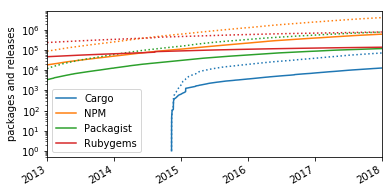

In [8]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()

for ecosystem in ECOSYSTEMS:
    df_tmp = (
        df_versions[ecosystem]
        .set_index('date')
        .sort_index()
    )
    
    data[ecosystem] = (
        df_tmp
        .drop_duplicates(['package'], keep='first')
        .assign(**{ecosystem: 1})
        [[ecosystem]]
        .cumsum()
        ,
        df_tmp
        .assign(**{ecosystem: 1})
        [[ecosystem]]
        .cumsum()        
    )
    
    data[ecosystem][0].plot(ax=ax, color=COLORS[ecosystem])
    data[ecosystem][1].plot(ax=ax, legend=False, style=':', color=COLORS[ecosystem])
    
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='packages and releases',
    yscale='log', 
)

#savefig(fig, 'overview_number_packages_releases')

In [9]:
for ecosystem in ECOSYSTEMS:
    print(ecosystem, data[ecosystem][0].max().values, data[ecosystem][1].max().values)

Cargo [14491] [80778]
NPM [676277] [4382693]
Packagist [126363] [832899]
Rubygems [143737] [825386]


[None,
 Text(0,0.5,'cumulative number of dependencies'),
 (734869.0, 736695.0),
 Text(0.5,0,'')]

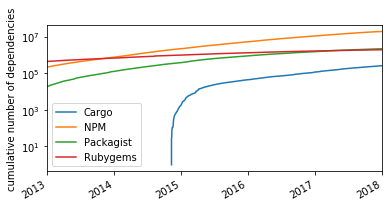

In [10]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_dependencies[ecosystem]
        .set_index('date')
        .sort_index()
        .assign(**{ecosystem: 1})
        [[ecosystem]]
        .cumsum()
    )
    data[ecosystem].plot(ax=ax, color=COLORS[ecosystem])
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='cumulative number of dependencies',
    yscale='log', 
)

#savefig(fig, 'overview_number_dependencies')

In [11]:
for ecosystem in ECOSYSTEMS:
    print(ecosystem, data[ecosystem].max().values)

Cargo [292470]
NPM [19669409]
Packagist [2273465]
Rubygems [1970396]


## Monthly proportion of parsed dependencies

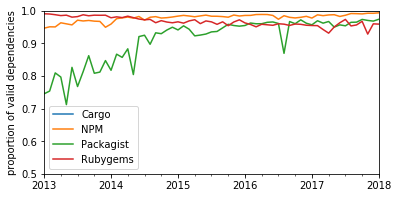

In [33]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_dependencies[ecosystem]
        .assign(version=1)        
        .groupby(pandas.Grouper(key='date', freq='1M'))
        [['empty', 'version']]
        .sum()
        .assign(**{ecosystem: lambda d: (d['version'] - d['empty']) / d['version']})
        [[ecosystem]]
    )
    data[ecosystem].plot(ax=ax, color=COLORS[ecosystem])
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='proportion of valid dependencies',
    ylim=(0.5, 1.00),
)

savefig(fig, 'overview_proportion_valid_dependencies')

In [35]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .assign(ecosystem=ecosystem)
    .describe()
for ecosystem in ECOSYSTEMS], axis=1)

,Cargo,NPM,Packagist,Rubygems
count,38.000000,60.000000,60.000000,60.000000
mean,0.999993,0.978316,0.909829,0.966960
std,0.000031,0.011300,0.069609,0.013949
min,0.999837,0.946450,0.712144,0.928383
25%,1.000000,0.975176,0.865587,0.958182
50%,1.000000,0.981921,0.942185,0.965634
75%,1.000000,0.985683,0.960370,0.978888
max,1.000000,0.992288,0.973335,0.990661


# Dependency constraint usage

## Monthly proportion of pre-1.0.0 constraints

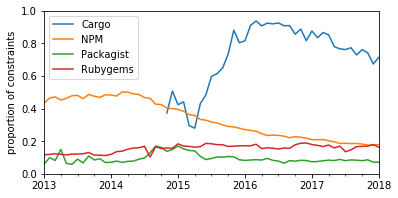

In [66]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_dependencies[ecosystem]
        .assign(zero=lambda d: d['dev'].astype(int))
        .assign(constraint=1)
        .groupby(pandas.Grouper(key='date', freq='1M'))
        [['constraint', 'zero']]
        .sum()
        .assign(**{ecosystem: lambda d: d['zero'] / d['constraint']})
        [[ecosystem]]
    )
    data[ecosystem].plot(ax=ax, color=COLORS[ecosystem])
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='proportion of constraints',
    ylim=(0, 1),
)

savefig(fig, 'dev_proportion_constraints')

In [38]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .assign(ecosystem=ecosystem)
    .describe()
for ecosystem in ECOSYSTEMS], axis=1)

,Cargo,NPM,Packagist,Rubygems
count,38.000000,60.000000,60.000000,60.000000
mean,0.727462,0.337873,0.094602,0.154944
std,0.192815,0.116117,0.027945,0.023695
min,0.279651,0.176047,0.058276,0.102568
25%,0.622591,0.226868,0.078071,0.135807
50%,0.776425,0.323098,0.084806,0.159490
75%,0.879634,0.463607,0.102035,0.171580
max,0.937238,0.502245,0.170219,0.188563


## Monthly proportion of required packages with a pre-1.0.0 reverse dependency constraint

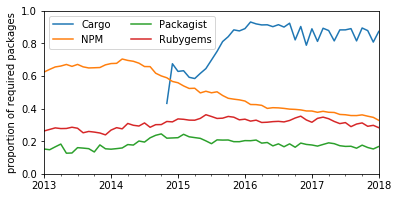

In [65]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_dependencies[ecosystem]
        .groupby(['target', pandas.Grouper(key='date', freq='1M')])
        .agg({'dev': 'max'})
        .reset_index('target', drop=True)
        .reset_index()
        .assign(required=1)
        .groupby(pandas.Grouper(key='date', freq='1M'))
        .sum()
        [lambda d: d['required'] > 0]
        .assign(**{ecosystem: lambda d: d['dev'] / d['required']})
    )
    
    data[ecosystem][[ecosystem]].plot(ax=ax, color=COLORS[ecosystem])
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='proportion of required packages',
    ylim=(0, 1),
)

ax.legend(ncol=2, loc='upper left')
savefig(fig, 'dev_proportion_required')

In [67]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .assign(ecosystem=ecosystem)
    .describe()
for ecosystem in ECOSYSTEMS], axis=1)

,Cargo,NPM,Packagist,Rubygems
count,38.000000,60.000000,60.000000,60.000000
mean,0.727462,0.337873,0.094602,0.154944
std,0.192815,0.116117,0.027945,0.023695
min,0.279651,0.176047,0.058276,0.102568
25%,0.622591,0.226868,0.078071,0.135807
50%,0.776425,0.323098,0.084806,0.159490
75%,0.879634,0.463607,0.102035,0.171580
max,0.937238,0.502245,0.170219,0.188563


## Monthly proportion of post-1.0.0 constraints w.r.t. semver

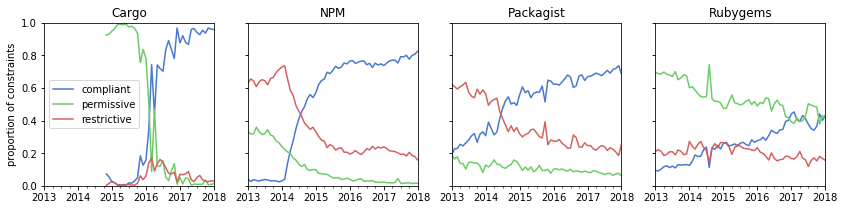

In [16]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=len(ECOSYSTEMS), sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

data = dict()
for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_dependencies[ecosystem]
        [lambda d: ~d['dev']]
        .assign(n=1)
        .groupby(pandas.Grouper(key='date', freq='M'))
        [['compliant', 'permissive', 'restrictive', 'n']]
        .sum()
        [lambda d: d['n'] > 0]
        .apply(lambda d: d / d['n'], axis=1)
        [['compliant', 'permissive', 'restrictive']]
    )
    
    data[ecosystem].plot(ax=ax, legend=False, color=SEC_PALETTE)
    ax.set(
        title=ecosystem,
        xlabel='',
        xlim=DATE_RANGE,
        ylabel='proportion of constraints',
        ylim=(0, 1),
    )
    
axes[0].legend(title=None, loc='center left')
savefig(fig, 'usage_compliance_post1')

## Monthly proportion of pre-1.0.0 constraints w.r.t. semver

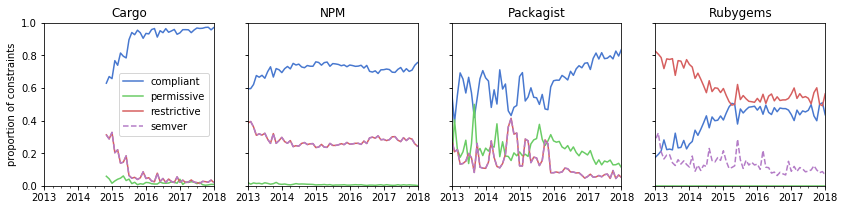

In [54]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=len(ECOSYSTEMS), sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

data = dict()
for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_dependencies[ecosystem]
        [lambda d: d['dev']]
        .assign(n=1)
        .groupby(pandas.Grouper(key='date', freq='M'))
        [['compliant', 'permissive', 'restrictive', 'semver_compliant', 'n']]
        .sum()
        [lambda d: d['n'] > 0]
        .apply(lambda d: d / d['n'], axis=1)
        .rename(columns={'semver_compliant': 'semver'})
        [['compliant', 'permissive', 'restrictive', 'semver']]
    )
    
    data[ecosystem][['compliant', 'permissive', 'restrictive']].plot(ax=ax, legend=False, color=SEC_PALETTE)
    data[ecosystem][['semver']].plot(ax=ax, legend=False, color=SEC_PALETTE[3], style='--')
    
    ax.set(
        title=ecosystem,
        xlabel='',
        xlim=DATE_RANGE,
        ylabel='proportion of constraints',
        ylim=(0, 1),
    )
    
axes[0].legend(title=None, loc='center right')
savefig(fig, 'usage_compliance_pre1')

# Constraint changes

## Monthly proportion of constraint changes

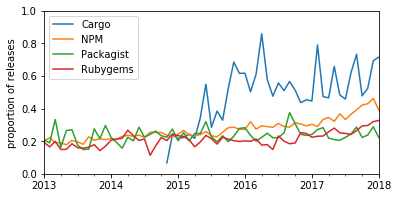

In [225]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()

for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_constraints[ecosystem]
        .assign(changes=1)
        .groupby(pandas.Grouper(key='constraint_next_date', freq='1M'))
        [['changes']]
        .sum()
        .merge(
            (
                df_versions[ecosystem]
                .assign(releases=1)
                .groupby(pandas.Grouper(key='date', freq='1M'))
                [['releases']]
                .sum()
            ),
            how='right',
            left_index=True,
            right_index=True,
        )
        .assign(**{ecosystem: lambda d: d['changes'] / d['releases']})
        [[ecosystem]]
    )
    
    data[ecosystem].plot(ax=ax, legend=False, color=COLORS[ecosystem])
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='proportion of releases',
    ylim=(0, 1),
)

ax.legend(title=None)

savefig(fig, 'change_monthly_evolution')

In [226]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .assign(ecosystem=ecosystem)
    .describe()
for ecosystem in ECOSYSTEMS], axis=1)

,Cargo,NPM,Packagist,Rubygems
count,38.000000,60.000000,60.000000,60.000000
mean,0.484797,0.269402,0.237405,0.209728
std,0.173415,0.062413,0.043738,0.041021
min,0.066667,0.178168,0.148733,0.113324
25%,0.397355,0.226728,0.209184,0.181473
50%,0.493202,0.254737,0.233462,0.206887
75%,0.602922,0.296588,0.266381,0.233701
max,0.858378,0.462061,0.375214,0.320042


## Duration of a constraint w.r.t. semver

Restrict to packages sufficiently updated. We consider the median value as a threshold:

In [20]:
df_frequently_updated = dict()

for ecosystem in ECOSYSTEMS:
    df_temp = (
        df_versions[ecosystem]
        .sort_values('rank')
        .drop_duplicates('package', keep='last')
        [lambda e: e['rank'] > e['rank'].median()]
    )
    print(ecosystem, df_temp['rank'].min())
    df_frequently_updated[ecosystem] = df_temp['package']

Cargo 4
NPM 4
Packagist 4
Rubygems 3


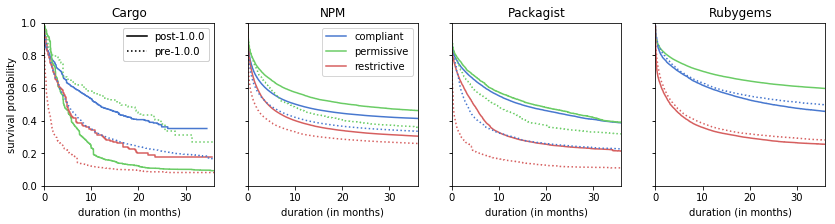

In [94]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

data = dict()

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_constraints[ecosystem]
        [lambda d: d['package'].isin(df_frequently_updated[ecosystem])]
        .assign(duration=lambda d: (d['constraint_next_date'].fillna(CENSOR_DATE) - d['date']) / pandas.to_timedelta(30, 'days'))
        .assign(observed=lambda d: ~d['constraint_next_date'].isnull())
    )
    
    kmf = lifelines.KaplanMeierFitter()
    for dev in (False, True):
        for j, constraint_type in enumerate(['compliant', 'permissive', 'restrictive']):
            mask = (lambda d: (d['dev'] == dev) & d[constraint_type])
            try:
                kmf.fit(data[ecosystem][mask]['duration'], data[ecosystem][mask]['observed'], label=constraint_type if not dev else '')
                kmf.plot(ax=ax, c=SEC_PALETTE[j], ci_show=False, legend=False, style=':' if dev else '-')
            except ValueError:
                pass
    ax.set(
        title=ecosystem,
        xlabel='duration (in months)',
        xlim=(0, 36),
        ylabel='survival probability',
        ylim=(0, 1),         
    )
    
legend = axes[0].legend(
    [matplotlib.lines.Line2D([0], [0], color='k'), matplotlib.lines.Line2D([0], [0], color='k', linestyle='dotted')],
    ['post-1.0.0', 'pre-1.0.0'],
)
axes[1].legend()
axes[0].add_artist(legend)

savefig(fig, 'change_constraint_duration')

In [100]:
for ecosystem in ECOSYSTEMS:
    print(ecosystem)
    
    for dev in (False, True):
        for A, B in itertools.combinations(['compliant', 'permissive', 'restrictive'], 2):
            mask_A = (lambda d: (d['dev'] == dev) & d[A])
            mask_B = (lambda d: (d['dev'] == dev) & d[B])
            
            try:
                test = logrank_test(
                    data[ecosystem][mask_A]['duration'], data[ecosystem][mask_B]['duration'],
                    data[ecosystem][mask_A]['observed'], data[ecosystem][mask_B]['observed'],
                    alpha=0.95,
                )
                print('({}) {} vs {}: {} ({:e})'.format('pre-1.0.0' if dev else 'post-1.0.0', A, B, (test.p_value < P_VALUE), test.p_value))
            except AssertionError:  # Don't know why lifelines does this?
                print('({}) {} vs {}: passed'.format('pre-1.0.0' if dev else 'post-1.0.0', A, B))
    
    print()
    for A in ['compliant', 'permissive', 'restrictive']:
        mask_A = (lambda d: ~d['dev'] & d[A])
        mask_B = (lambda d: d['dev'] & d[A])
        try:
            test = logrank_test(
                data[ecosystem][mask_A]['duration'], data[ecosystem][mask_B]['duration'],
                data[ecosystem][mask_A]['observed'], data[ecosystem][mask_B]['observed'],
                alpha=0.95,
            )
            print('({}) post-1.0.0 vs. pre-1.0.0: {} ({:e})'.format(A, test.p_value < P_VALUE, test.p_value))
        except (AssertionError, ValueError):  # Don't know why lifelines does this?
            print('({}) post-1.0.0 vs. pre-1.0.0: passed'.format(A))
    
    print()

Cargo
(post-1.0.0) compliant vs permissive: True (2.399494e-165)
(post-1.0.0) compliant vs restrictive: True (1.625471e-14)
(post-1.0.0) permissive vs restrictive: True (2.374461e-03)
(pre-1.0.0) compliant vs permissive: True (2.795560e-20)
(pre-1.0.0) compliant vs restrictive: True (0.000000e+00)
(pre-1.0.0) permissive vs restrictive: True (3.167487e-92)

(compliant) post-1.0.0 vs. pre-1.0.0: True (1.778875e-126)
(permissive) post-1.0.0 vs. pre-1.0.0: True (4.582060e-43)
(restrictive) post-1.0.0 vs. pre-1.0.0: True (8.139719e-45)

NPM
(post-1.0.0) compliant vs permissive: True (4.739493e-232)
(post-1.0.0) compliant vs restrictive: True (0.000000e+00)
(post-1.0.0) permissive vs restrictive: True (0.000000e+00)
(pre-1.0.0) compliant vs permissive: True (5.085252e-15)
(pre-1.0.0) compliant vs restrictive: True (0.000000e+00)
(pre-1.0.0) permissive vs restrictive: True (5.100615e-87)

(compliant) post-1.0.0 vs. pre-1.0.0: True (0.000000e+00)
(permissive) post-1.0.0 vs. pre-1.0.0: True (3.

## Proportion of changes w.r.t. original and new constraint semantics

Restricted to 2017 (to limit the impact of some ecosystem-specific changes).

In [210]:
data = dict()

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_constraints[ecosystem]
        # [lambda d: d['dev']]
        [lambda d: d['constraint_next_date'].between(pandas.to_datetime('2017-01-01'), pandas.to_datetime('2018-01-01'))]
        .assign(
           kind=lambda d: d[['compliant', 'permissive', 'restrictive']].apply(lambda s: s.values.argmax(), axis=1)
        )
        .pipe(lambda d: 
            d[['package', 'target', 'kind', 'constraint_next_rank']]
            .merge(
                d[['package', 'target', 'kind', 'rank']],
                how='inner',
                left_on=['package', 'target', 'constraint_next_rank'],
                right_on=['package', 'target', 'rank'],
                suffixes=('', '_new'),
            )        
        )
        .assign(n=1)
        .groupby(['kind', 'kind_new'], as_index=False)
        [['n']]
        .count()
        .replace({
            'kind': {0: 'compliant', 1: 'permissive', 2: 'restrictive'},
            'kind_new': {0: 'compliant', 1: 'permissive', 2: 'restrictive'},
        })
        .pivot('kind', 'kind_new', 'n')
        .apply(lambda s: s / s.sum(), axis=1)    
    )

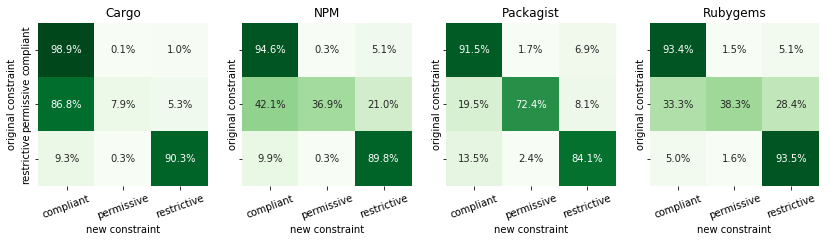

In [211]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    seaborn.heatmap(
        (
            data[ecosystem]
            .reset_index()
            .set_index('kind')
            .fillna(0)
            [['compliant', 'permissive', 'restrictive']]
            .loc[['compliant', 'permissive', 'restrictive']]
        ),
        annot=True, 
        cmap='Greens',
        cbar=False,
        fmt='.1%',
        center=0.5,
        ax=ax
    )
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(20)
        # tick.set_horizontalalignment('right')
    for tick in ax.get_yticklabels():
        tick.set_rotation(90)
        tick.set_verticalalignment('center')
    
    ax.set(
        title=ecosystem,
        xlabel='new constraint',
        ylabel='original constraint',
    )
    
savefig(fig, 'change_proportion_original_new')

# Constraint specialization

A package is said to be *specialized* if a large proportion of its reverse dependencies agree on their constraints (i.e. they are either compliant, permissive or restrictive).

## Preferential attachment

Packages that are already required with a specialized kind of constraints are likely to attract the same kind of constraints.

## Proportion of required packages that are specialized

For this analysis, we restricted the set of packages that were active after 2017-01-01, and we consider the dependencies of the highest available version of each package during this period. Finally, we restricted the set of *required packages* to the one that are at least required by 2 other packages with non pre-1.0.0 constraints.

In [25]:
threshold = 0.95
min_required = 2

mask = lambda d: (
    d
    [lambda d: d['date'] >= pandas.to_datetime('2017-01-01')]
    [lambda d: ~d['dev']]
    .sort_values('rank')
    .drop_duplicates(['package', 'target'], keep='last')
)

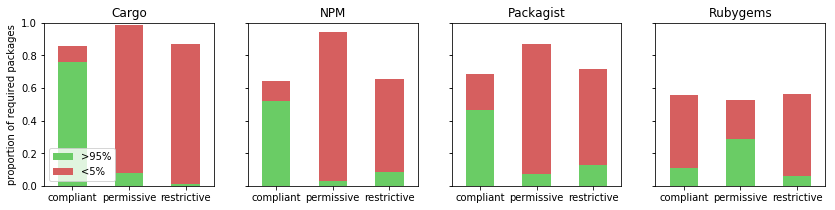

In [26]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

data = dict()
for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_dependencies[ecosystem]
        .pipe(mask)
        .assign(dependents=1)
        .groupby(['target'], sort=False)
        [['dependents', 'compliant', 'permissive', 'restrictive']]
        .sum()
        [lambda d: d['dependents'] >= min_required]
        .pipe(lambda d: d.apply(lambda s: s / d['dependents']))
        .pipe(
            pandas.melt,
            value_vars=['compliant', 'permissive', 'restrictive'],
            var_name='constraint', 
            value_name='proportion',
        )
        .assign(
            above=lambda d: d['proportion'] >= threshold,
            below=lambda d: d['proportion'] <= (1 - threshold),
            inside=lambda d: (d['proportion'] < threshold) & (d['proportion'] > (1 - threshold))
        )
        .groupby('constraint', sort=False)
        [['above', 'inside', 'below']]
        .sum()
        .apply(lambda s: s / s.sum(), axis=1)
        .reset_index()
    )
    
    (
        data[ecosystem]
        [['constraint', 'above', 'below']]
        .rename(columns={
            'above': '>{:.0%}'.format(threshold), 
            #'inside': '{:.0%}-{:.0%}'.format(*threshold), 
            'below': '<{:.0%}'.format(1 - threshold)
        })
        .plot.bar(x='constraint', stacked=True, color=[SEC_PALETTE[1], SEC_PALETTE[2]], ax=ax)
    )
    
    ax.set(
        title=ecosystem,
        xlabel='',
        ylabel='proportion of required packages',
        ylim=(0, 1),
    )
    ax.legend().remove()
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)

axes[0].legend(loc='lower left')
savefig(fig, 'required_specialization_accept_reject_stacked')

In [27]:
(
    pandas.concat([df.assign(ecosystem=ecosystem) for ecosystem, df in data.items()])
    [['ecosystem', 'constraint', 'above', 'below', 'inside']]
)

,ecosystem,constraint,above,below,inside
0,Packagist,compliant,0.463872,0.219112,0.317016
1,Packagist,permissive,0.071962,0.799209,0.128829
2,Packagist,restrictive,0.124579,0.589770,0.285651
0,Rubygems,compliant,0.108941,0.446281,0.444778
1,Rubygems,permissive,0.284373,0.240421,0.475207
2,Rubygems,restrictive,0.057476,0.508264,0.434260
0,NPM,compliant,0.517503,0.123149,0.359347
1,NPM,permissive,0.029874,0.912187,0.057939
2,NPM,restrictive,0.082385,0.569487,0.348128
0,Cargo,compliant,0.761702,0.093617,0.144681


## Monthly evolution of the number of specialized packages

... based on the constraints that are declared during the month.
All constraints are considered, but only required packages with at least some dependents are considered.

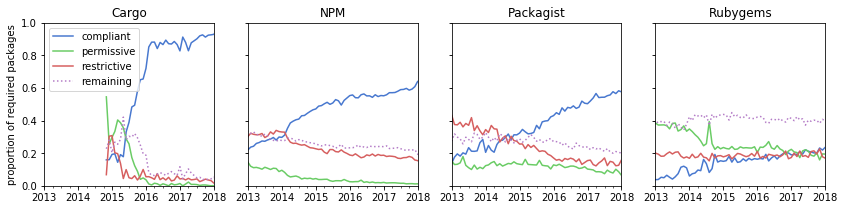

In [207]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

data = dict()
for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_dependencies[ecosystem]
        .assign(dependents=1)
        .groupby(['target', pandas.Grouper(key='date', freq='M')], sort=False)
        [['dependents', 'compliant', 'permissive', 'restrictive']]
        .sum()
        [lambda d: d['dependents'] >= min_required]
        .reset_index(level='target', drop=True)
        .assign(
            compliant=lambda d: d['compliant'] >= threshold * d['dependents'],
            permissive=lambda d: d['permissive'] >= threshold * d['dependents'],
            restrictive=lambda d: d['restrictive'] >= threshold * d['dependents'],
        )
        .drop(columns=['dependents'])
        .assign(required=1)
        .groupby(level='date')
        .sum()
        .apply(lambda d: d / d['required'], axis=1)
        .assign(remaining=lambda d: 1 - d['compliant'] - d['permissive'] - d['restrictive'])
    )
    
    (
        data[ecosystem]
        [['compliant', 'permissive', 'restrictive', 'remaining']]
        .rename(columns={
        #    'compliant': 'mostly compliant',
        #    'permissive': 'mostly permissive', 
        #    'restrictive': 'mostly restrictive',
        })
        .plot(ax=ax, legend=False, color=SEC_PALETTE, style=['-', '-', '-', ':'])
    )
        
    ax.set(
        title=ecosystem,
        xlabel='',
        xlim=DATE_RANGE,
        ylabel='proportion of required packages',
        ylim=(0, 1),
    )
    
# axes[-1].legend(loc='upper left', ncol=4, bbox_to_anchor=(-2, 1))
axes[0].legend(loc='upper left')

savefig(fig, 'required_specialized_by_month')

# Identifying breaking changes?

In [182]:
packages = [
    ('NPM', 'underscore', '1.7.0'),
    ('NPM', 'underscore', '1.8.0'),
    ('Rubygems', 'i18n', '0.5.0'),
    ('NPM', 'typescript', '2.1.1'),
]

timeframe = (pandas.to_timedelta('365D'), pandas.to_timedelta('365D'))

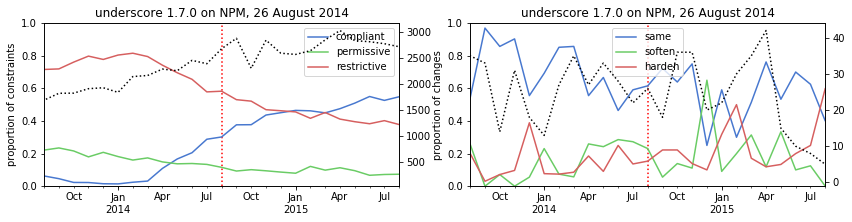

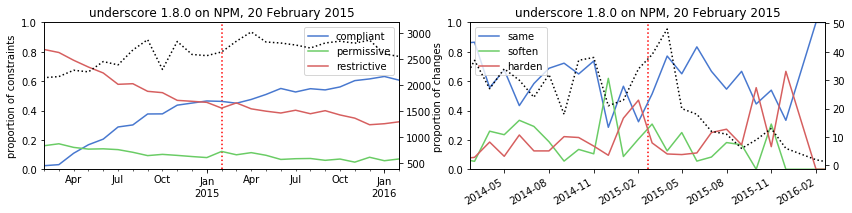

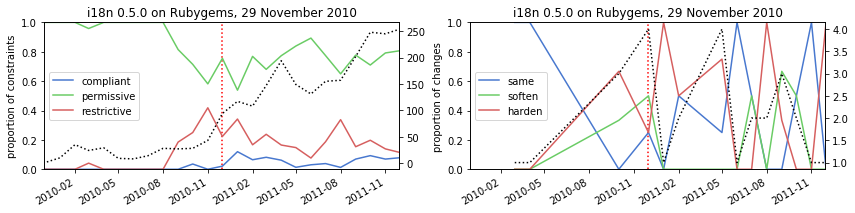

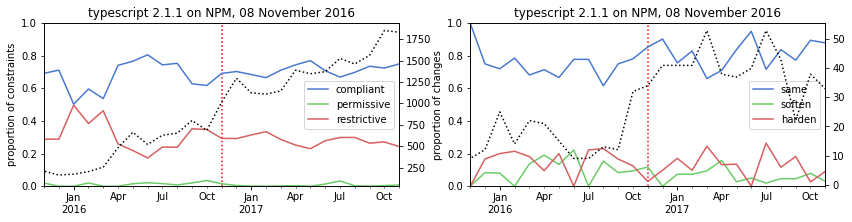

In [215]:
for ecosystem, package, version in packages:
    fig, (ax, ax2) = matplotlib.pyplot.subplots(ncols=2)
    fig.set_size_inches(FIG_SIZE_WIDE[0], FIG_SIZE[1])
    
    date = df_versions[ecosystem][lambda d: (d['package'] == package) & (d['version'] == version)]['date'].iloc[0]
    
    _ = (
        df_dependencies[ecosystem]
        [lambda d: d['target'] == package]
        [lambda d: d['date'].between(date - pandas.to_timedelta('90D') - timeframe[0], date + timeframe[1] + pandas.to_timedelta('90D'))]
        .assign(constraints=1)
        .groupby(pandas.Grouper(key='date', freq='M'))
        [['constraints', 'compliant', 'permissive', 'restrictive']]
        .sum()
        [lambda d: d['constraints'] > 0]
        .assign(
            compliant=lambda d: d['compliant'] / d['constraints'],
            permissive=lambda d: d['permissive'] / d['constraints'],
            restrictive=lambda d: d['restrictive'] / d['constraints'],
        )
        [['compliant', 'permissive', 'restrictive', 'constraints']]
    )
    _.index = _.index + pandas.to_timedelta('1D')
    
    _.drop(columns=['constraints']).plot(ax=ax, color=SEC_PALETTE)
    _[['constraints']].plot(ax=ax, secondary_y=True, legend=False, color='k', style=':')
    
    ax.vlines(date, 0, 1, colors='r', linestyles='dotted')
    ax.set(
        title='{} {} on {}, {}'.format(package, version, ecosystem, date.strftime('%d %B %Y')),
        xlabel='',
        xlim=(date - timeframe[0], date + timeframe[1]),
        ylabel='proportion of constraints',
        ylim=(0, 1),
    )
    
    
    ########################################
    
    ax = ax2
    
    _ = (
        df_constraints[ecosystem]
        [lambda d: d['target'] == package]
        [lambda d: d['constraint_next_date'].between(date - pandas.to_timedelta('90D') - timeframe[0], date + timeframe[1] + pandas.to_timedelta('90D'))]
        .assign(kind=lambda d: d[['restrictive', 'compliant', 'permissive']].apply(lambda s: s.values.argmax(), axis=1))
        [['package', 'target', 'constraint_next_date', 'rank', 'kind', 'constraint_next_rank']]
        .pipe(lambda df: 
            df.merge(
                df, how='inner', left_on=['package', 'target', 'constraint_next_rank'], right_on=['package', 'target', 'rank'],
                suffixes=('', '_new'),
            )
        )
        .assign(
            changes=1, 
            same=lambda d: d['kind_new'] == d['kind'],
            soften=lambda d: d['kind_new'] > d['kind'],
            harden=lambda d: d['kind_new'] < d['kind'],
        )
        .groupby(pandas.Grouper(key='constraint_next_date', freq='M'))
        [['changes', 'same', 'soften', 'harden']]
        .sum()
        [lambda d: d['changes'] > 0]
    )

    _.index = _.index + pandas.to_timedelta('1D')
    
    _.apply(lambda s: s / s['changes'], axis=1).drop(columns=['changes']).plot(ax=ax, legend=True, color=SEC_PALETTE)
    _[['changes']].plot(ax=ax, secondary_y=True, legend=False, color='k', style=':')
    
    ax.vlines(date, 0, 1, colors='r', linestyles='dotted')
    ax.set(
        title='{} {} on {}, {}'.format(package, version, ecosystem, date.strftime('%d %B %Y')),
        xlabel='',
        xlim=(date - timeframe[0], date + timeframe[1]),
        ylabel='proportion of changes',
        ylim=(0, 1),
    )
    